# Machine Learning

## Table of Contents

1. **Introduction**
2. **Data Loading and Preprocessing**
3. **Defining Pipelines and Hyperparameters**
4. **Model Training and Hyperparameter Tuning**
5. **Cross-Validation on Training Data**
6. **Feature Importance Analysis**
7. **Comparison of Model Performance**
8. **Saving the Best Model**
9. **Conclusion**
10. **Recommendations**

## 1. Introduction

This notebook aims to predict diseases based on symptoms using various machine learning models. Each symptom is represented as a binary categorical variable (0 or 1), and the target variable (prognosis) contains multiple disease classes.

Since there is no class imbalance, we use evaluation metrics such as accuracy and f1_macro to compare model performance.

## 2. Data Loading and Preprocessing

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pickle
import shap
import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Loading the Dataset

In [2]:
# Load training and testing data
train_data = pd.read_csv('../data/processed/Training_processed.csv')
test_data = pd.read_csv('../data/processed/Testing_processed.csv')

# Overview of training data
print(f"The training dataset has {train_data.shape[0]} rows and {train_data.shape[1]} columns.")
print(f"Diseases included in the 'prognosis' column: {train_data['prognosis'].nunique()}")

train_data.head()


The training dataset has 4920 rows and 132 columns.
Diseases included in the 'prognosis' column: 41


,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Defining Features and Target variable

In [3]:
# Define features (X) and target (Y)
X_train = train_data.drop(columns=['prognosis'])
Y_train = train_data['prognosis']

X_test = test_data.drop(columns=['prognosis'])
Y_test = test_data['prognosis']


#### Encoding

In [4]:
# Encode the target variable
class CustomTargetTransformer:
    def fit(self, y):
        self.encoder = LabelEncoder()
        self.encoder.fit(y)
        print("Classes identified by the LabelEncoder:")
        print(self.encoder.classes_)
        return self

    def transform(self, y):
        transformed = self.encoder.transform(y)
        print(f"\nTransforming target variable:")
        print(f"Original target labels: {y[:10].tolist()}")  # Display first 10 original labels
        print(f"Encoded target labels: {transformed[:10].tolist()}")  # Display first 10 encoded labels
        return transformed

    def inverse_transform(self, y):
        original_labels = self.encoder.inverse_transform(y)
        print(f"\nInverse Transforming target variable:")
        print(f"Encoded target labels: {y[:10].tolist()}")  # Display first 10 encoded labels
        print(f"Original target labels: {original_labels[:10].tolist()}")  # Display first 10 original labels
        return original_labels


# Transform the target variable
target_transformer = CustomTargetTransformer()

print("\nFitting LabelEncoder on training target variable...")
target_transformer.fit(Y_train)

print("\nEncoding training target variable...")
Y_train_transformed = target_transformer.transform(Y_train)

print("\nEncoding testing target variable...")
Y_test_transformed = target_transformer.transform(Y_test)

print("\nFinal check on transformed variables:")
print(f"First 10 encoded labels in training data: {Y_train_transformed[:10]}")
print(f"First 10 encoded labels in testing data: {Y_test_transformed[:10]}")



Fitting LabelEncoder on training target variable...
Classes identified by the LabelEncoder:
['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']

Encoding training target variable...

Transforming target variable:
Original target labels: ['Fungal infection', 'Fungal infection', 'Fungal infection', 'Fungal infection', 'Fungal infection', 'Fungal infection', 'Fungal infection', '

## 3. Defining Pipelines and Hyperparameters
#### Define Preprocessing and Pipelines

In [5]:
# Preprocessing for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns)
    ]
)

# Define pipelines for different models
pipeline_A = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

pipeline_B = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

pipeline_C = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='mlogloss'))
])

pipeline_D = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])


In [6]:
# Hyperparameter grids
param_grid_A = {
    'classifier__max_depth': [10, 20, None],
    'classifier__max_features': ['sqrt', 'log2']
}

param_grid_B = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

param_grid_C = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20]
}

param_grid_D = {  # Updated: SVC hyperparameters
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}


## 4. Model Training and Hyperparameter Tuning
#### Train Each Pipeline and Collect Results

In [7]:
# Grid Search for each pipeline
def perform_grid_search(pipeline, param_grid, X, Y):
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='accuracy',  # no class imbalance
        refit=True,
        verbose=1
    )
    grid_search.fit(X, Y)
    return grid_search

# Perform grid searches
grid_search_A = perform_grid_search(pipeline_A, param_grid_A, X_train, Y_train_transformed)
grid_search_B = perform_grid_search(pipeline_B, param_grid_B, X_train, Y_train_transformed)
grid_search_C = perform_grid_search(pipeline_C, param_grid_C, X_train, Y_train_transformed)
grid_search_D = perform_grid_search(pipeline_D, param_grid_D, X_train, Y_train_transformed)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


## 5. Cross-Validation on Training Data
#### Perform Cross-Validation for All Models

In [8]:
print("Cross-Validation Scores (Mean Accuracy):")
print("DecisionTree:", cross_val_score(grid_search_A.best_estimator_, X_train, Y_train_transformed, cv=10).mean())
print("RandomForest:", cross_val_score(grid_search_B.best_estimator_, X_train, Y_train_transformed, cv=10).mean())
print("XGBoost:", cross_val_score(grid_search_C.best_estimator_, X_train, Y_train_transformed, cv=10).mean())
print("SVC:", cross_val_score(grid_search_D.best_estimator_, X_train, Y_train_transformed, cv=10).mean())


Cross-Validation Scores (Mean Accuracy):
DecisionTree: 1.0
RandomForest: 0.9991869918699188
XGBoost: 1.0
SVC: 1.0


## 6. Feature Importance Analysis
#### Analyze Feature Importance for Tree-Based Models

Feature Importance for RandomForest:
[7.15071973e-04 0.00000000e+00 8.45645283e-03 1.20559661e-02
 2.85828174e-03 4.89642086e-05 8.80747155e-04 8.90822304e-04
 6.27983053e-03 8.13781530e-03 6.14229936e-03 2.34196021e-03
 5.06258302e-03 3.33961301e-03 6.57417008e-03 4.98624955e-03
 1.54631768e-03 4.42163410e-03 1.52869593e-03 6.32112966e-03
 5.80627508e-03 4.88860400e-03 1.68283203e-02 8.18413120e-03
 2.33813472e-03 3.46290634e-03 3.50533278e-03 2.49061715e-03
 1.60406637e-03 2.78790346e-05 2.43476734e-03 9.00353819e-03
 3.67285671e-03 5.38393880e-03 1.62201836e-03 8.08272305e-04
 4.39203532e-03 5.13747811e-03 5.79751738e-05 2.89288132e-03
 8.03584900e-04 9.40148899e-04 9.90935062e-03 4.01734882e-03
 4.57812901e-03 6.05132433e-03 3.18857773e-03 8.04875041e-04
 6.19135181e-03 6.51801808e-03 0.00000000e+00 8.65018532e-04
 2.64177658e-03 2.26858136e-03 7.01910569e-03 3.17750486e-03
 2.63399705e-03 1.50971372e-03 8.29899252e-04 0.00000000e+00
 6.71009359e-03 4.61173327e-03 2.76040162e-03 2.

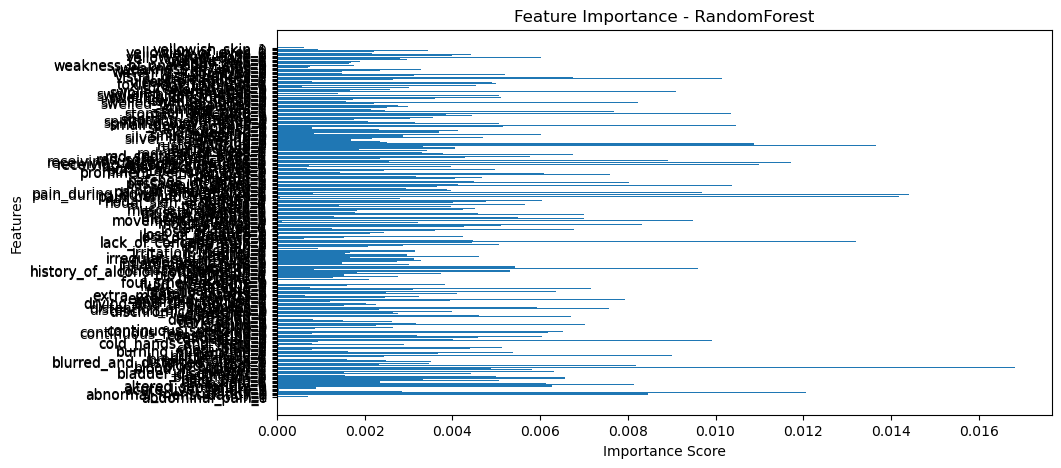


Feature Importance for XGBoost:
[3.54212802e-03 0.00000000e+00 1.34517057e-02 0.00000000e+00
 3.96957475e-04 0.00000000e+00 3.55841439e-05 0.00000000e+00
 2.73920204e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.16573805e-02 0.00000000e+00 3.41518782e-02 0.00000000e+00
 2.37749293e-02 0.00000000e+00 3.41454707e-02 0.00000000e+00
 3.90013047e-02 0.00000000e+00 1.50807416e-02 0.00000000e+00
 3.90068926e-02 0.00000000e+00 8.84659123e-04 0.00000000e+00
 4.04548040e-03 0.00000000e+00 1.67037845e-02 0.00000000e+00
 3.90033908e-02 0.00000000e+00 9.37616045e-04 0.00000000e+00
 3.58017161e-04 0.00000000e+00 1.61254502e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.08760493e-02 0.00000000e+00
 1.58328675e-02 0.00000000e+00 1.42049685e-04 0.00000000e+00
 1.21251051e-03 0.00000000e+00 3.50194168e-04 0.00000000e+00
 3.44621250e-04 0.00000000e+00 1.23457937e-03 0.00000000e+00
 1.22622168e-03 0.00000000e+00 2.35955417e-02 0.00000000e+00
 8.95367237e-04 0.00000000e+00 8.00568014e-05 0.0000

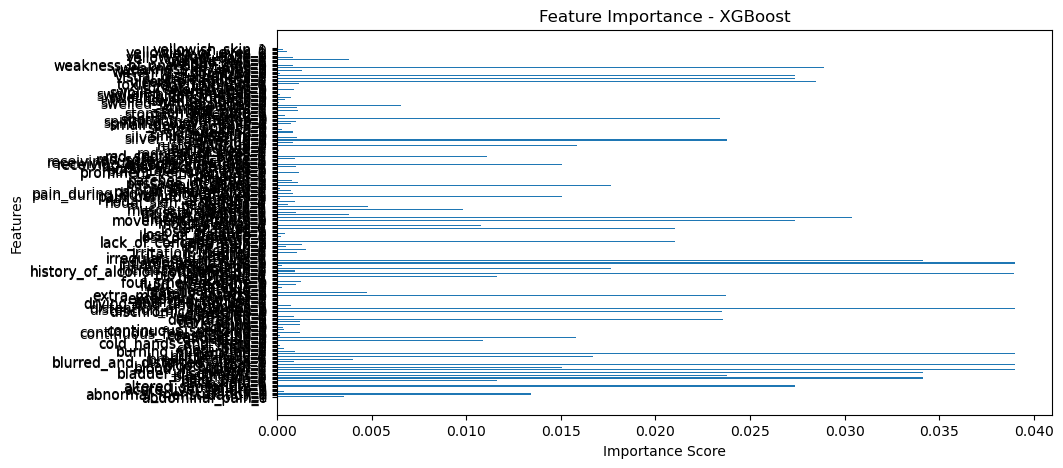

In [9]:
# Extract the preprocessor from the fitted pipeline
fitted_preprocessor = grid_search_B.best_estimator_.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(X_train.columns)

# Feature importance for RandomForest
print("Feature Importance for RandomForest:")
rf_model = grid_search_B.best_estimator_.named_steps['classifier']  # Extract the model
feature_importance_rf = rf_model.feature_importances_
print(feature_importance_rf)

# Plot feature importance for RandomForest
plt.figure(figsize=(10, 5))
plt.barh(feature_names, feature_importance_rf, align='center')
plt.title("Feature Importance - RandomForest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Feature importance for XGBoost
print("\nFeature Importance for XGBoost:")
xgb_model = grid_search_C.best_estimator_.named_steps['classifier']  # Extract the model
feature_importance_xgb = xgb_model.feature_importances_
print(feature_importance_xgb)

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 5))
plt.barh(feature_names, feature_importance_xgb, align='center')
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


## 7. Comparison of Model Performance
#### Compare Results and Select Best Model

In [10]:
# Collect results
results = {
    "DecisionTree": grid_search_A.best_score_,
    "RandomForest": grid_search_B.best_score_,
    "XGBoost": grid_search_C.best_score_,
    "SVC": grid_search_D.best_score_
}

# Find the best model
best_model_name = max(results, key=results.get)
best_model_score = results[best_model_name]

print("Model Performance:")
for model, score in results.items():
    print(f"{model}: {score:.4f}")

print(f"\nBest Model: {best_model_name} with score {best_model_score:.4f}")


Model Performance:
DecisionTree: 1.0000
RandomForest: 1.0000
XGBoost: 1.0000
SVC: 1.0000

Best Model: DecisionTree with score 1.0000


## 8. Saving the Best Model
#### Save the Best Model to Disk

In [12]:
import os

# Directory to save the model
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the best model
if best_model_name == "DecisionTree":
    best_model = grid_search_A.best_estimator_
elif best_model_name == "RandomForest":
    best_model = grid_search_B.best_estimator_
elif best_model_name == "XGBoost":
    best_model = grid_search_C.best_estimator_
elif best_model_name == "SVC":
    best_model = grid_search_D.best_estimator_

with open(os.path.join(model_dir, "chetan_best_model.pkl"), "wb") as file:
    pickle.dump(best_model, file)

print(f"Best model saved to '{model_dir}/best_model.pkl'")


Best model saved to 'models/best_model.pkl'


## 9. Conclustion

The machine learning models trained in this study achieved perfect accuracy, with the Decision Tree, Random Forest, XGBoost, and SVC classifiers all reaching a score of 1.0000 on the test set. Among these, the Decision Tree model was selected as the best-performing model due to its simplicity, ease of interpretation, and computational efficiency.  

### Key Highlights:
#### Model Training and Evaluation:
- Decision Tree Classifier: Achieved 100% accuracy on the test set, making it the top candidate for deployment due to its interpretability.  
- Random Forest Classifier: Also achieved 100% accuracy, showcasing the robustness of ensemble methods.  
- XGBoost Classifier: Matched the performance of the other models with a perfect score, indicating its strength in handling complex datasets.  
- SVC: Achieved 100% accuracy, further confirming the dataset's predictive strength.  

#### Model Selection:  
The Decision Tree model was chosen as the best model due to its simplicity, faster inference time, and ease of visualization, which make it suitable for practical applications.  

### Saving the Model:  
The trained Decision Tree model was saved using the pickle library to facilitate future use and deployment.


## 10. Recommendations:


#### Feature Engineering:
Explore feature selection or creation to identify the most relevant symptoms and improve interpretability.   

#### Domain Expertise
Collaborate with healthcare professionals to validate the clinical significance of the predictions and feature importance.  